In [1]:
if (!requireNamespace("BiocManager")) install.packages("BiocManager")
if (!requireNamespace("tidyverse")) install.packages("tidyverse")
if (!requireNamespace("flowCore")) BiocManager::install("flowCore")
if (!requireNamespace("cowplot")) install.packages("cowplot")
if (!requireNamespace("sf")) install.packages("sf")
if (!requireNamespace("scales")) install.packages("scales")
if (!requireNamespace("ggokabeito")) install.packages("ggokabeito")
if (!requireNamespace("ggpattern")) install.packages("ggpattern")
if (!requireNamespace("ggsignif")) install.packages("ggsignif")
if (!requireNamespace("flextable")) install.packages("flextable")
if (!requireNamespace("readxl")) install.packages("readxl")
if (!requireNamespace("egg")) install.packages("egg")
if (!requireNamespace("writexl")) install.packages("writexl")
if (!requireNamespace("devtools")) install.packages("devtools")
if (!requireNamespace("bardlab.flow")) devtools::install_github("jbardlab/bardlab_rcode", subdir = "bardlab_flow") #flow cytometry utility functions

library(tidyverse)
library(flowCore)
library(cowplot)
library(conflicted)
library(bardlab.flow)
conflicts_prefer(dplyr::filter)

theme_set(theme_minimal_grid(font_size = 12))
okabe_ito_colors <- palette.colors(n = NULL, palette = "Okabe-Ito", recycle = FALSE)

Loading required namespace: BiocManager
Loading required namespace: tidyverse
Loading required namespace: flowCore
Loading required namespace: cowplot
Loading required namespace: sf
Loading required namespace: ggokabeito
Loading required namespace: ggpattern
Loading required namespace: ggsignif
Loading required namespace: flextable
Loading required namespace: readxl
Loading required namespace: egg
Loading required namespace: writexl
Loading required namespace: devtools
Loading required namespace: bardlab.flow
── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflic

In [2]:
wrk.dir <- "/Users/jbard/Library/CloudStorage/SynologyDrive-home/repos/bardlab_rcode/R_templates/Flow"
data_folder <-  file.path(wrk.dir,"data") # adjust this to your data!
# generate the sample name spreadsheet
fcs_files <- list.files(path = data_folder, pattern = ".fcs", full.names = FALSE)
tib_samples <- tibble(fileName = fcs_files) %>%
  mutate(sample_ID = str_replace(fileName,".fcs","")) %>%
  separate(sample_ID, into = c("Well", "FP", "Conc"), sep = " ", remove = F)
write_csv(tib_samples, path = file.path(wrk.dir,"sample_names.csv"))

Warning message:
The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
ℹ Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 


In [3]:
fs <- read.flowSet(path = file.path(data_folder),pattern = ".fcs",alter.names = T)

tib_fs <- extract_fcs_exprs(fs) %>%
  left_join(tib_samples, by = "fileName")

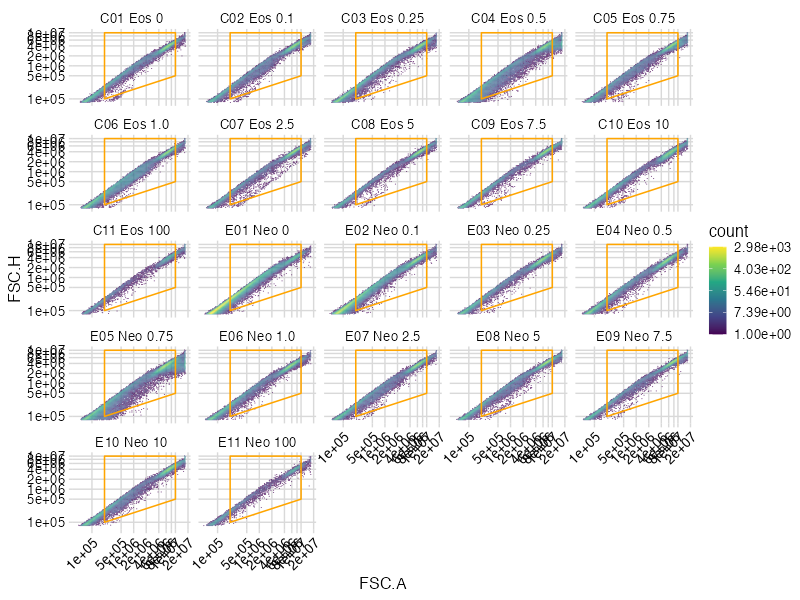

In [4]:
# draw polygons as (x1, x2, x3, x4, x5) and (y1, y2, y3, y4, y5)
default_FSC.A <- c(2e5, 2e5, 1e7, 1e7, 2e5) # need to be closed polygons (repeat the first point as the last point)
default_FSC.H = c(1e5, 1e7, 1e7, 5e5, 1e5)

# first generate a tibble with the same gates for every sample
sample_IDs <- tib_fs$sample_ID %>% unique

# Create singlet_gates programmatically
singlet_gates <- map(sample_IDs, ~tibble(FSC.A = default_FSC.A, FSC.H = default_FSC.H))
names(singlet_gates) <- sample_IDs

# if you need to adjust a particular gate, you can do that manually now:
# singlet_gates[["C01"]] <- tibble(FSC.A = c(1,1,2,2,1),
#                                  FSC.H = c(1,2,2,1,1))

# create a tibble for plotting:
singlet_gates_long <- bind_rows(
  map2(sample_IDs, singlet_gates, ~mutate(.y, sample_ID = .x)) # adds a column with the sample_ID to every gate
)

# finally assemble into a tibble for the join operation below
tib_singlet_gates <- tibble(
  sample_ID = sample_IDs,
  polygon = singlet_gates
)

p_singlet <- ggplot(data = tib_fs,
       aes(x=FSC.A, y=FSC.H)) +
  geom_hex(bins = 100) +
  #geom_point(alpha=0.05,size=0.5,color="grey50") +
  geom_polygon(data = singlet_gates_long, aes(x = FSC.A, y = FSC.H), fill = NA, color = "orange") +  # Polygon
  scale_fill_viridis_c(trans = "log", labels = scales::label_scientific()) +
  scale_x_continuous(trans = asinh_trans(), breaks = c(1e5, 5e5, 1e6, 2e6, 4e6, 6e6, 8e6, 1e7, 2e7)) + 
  scale_y_continuous(trans = asinh_trans(), breaks = c(1e5, 5e5, 1e6, 2e6, 4e6, 6e6, 8e6, 1e7, 2e7)) +
  facet_wrap(facets = "sample_ID")+
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
p_singlet

In [5]:
tib_fs_singlet <- tib_fs %>%
  group_by(sample_ID) %>%
  nest %>%
  left_join(tib_singlet_gates, by = "sample_ID") %>%
  mutate(Singlet = map2(data, polygon, check_points_within_polygon,"FSC.A","FSC.H","asinh")) %>%
  select(-polygon) %>%
  unnest(c(data,Singlet)) %>%
  filter(Singlet == TRUE)

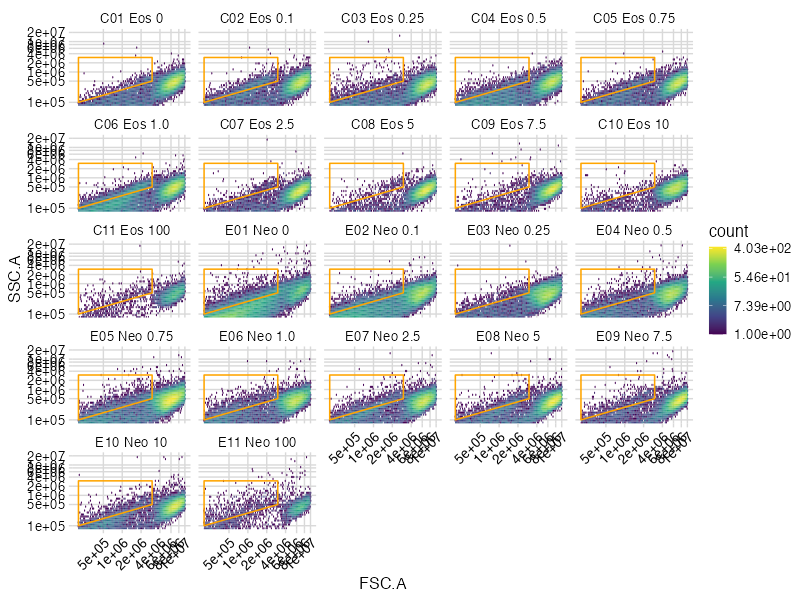

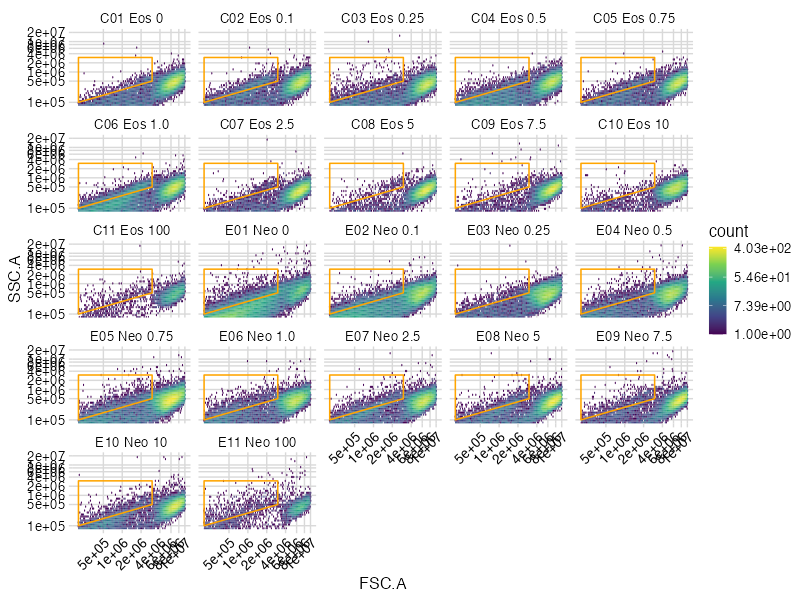

In [7]:
# draw polygons as (x1, x2, x3, x4, x5) and (y1, y2, y3, y4, y5)

default_FSC.A <-  c(2e5, 2e5, 3e6, 3e6, 2e5) # need to be closed polygons (repeat the first point as the last point)
default_SSC.A = c(1e5, 3e6, 3e6, 5e5, 1e5)

# first generate a tibble with the same gates for every sample
sample_IDs <- tib_fs$sample_ID %>% unique

# Create live_gates programmatically
live_gates <- map(sample_IDs, ~tibble(FSC.A = default_FSC.A, SSC.A = default_SSC.A))
names(live_gates) <- sample_IDs

# if you need to adjust a particular gate, you can do that manually now:
# live_gates[["C01"]] <- tibble(FSC.A = c(1,1,2,2,1),
#                                  SSC.A = c(1,2,2,1,1))

# create a tibble for plotting:
live_gates_long <- bind_rows(
  map2(sample_IDs, live_gates, ~mutate(.y, sample_ID = .x)) # adds a column with the sample_ID to every gate
)

# finally assemble into a tibble for the join operation below
tib_live_gates <- tibble(
  sample_ID = sample_IDs,
  polygon = live_gates
)

p_live <- ggplot(data = tib_fs_singlet %>% filter(Singlet == TRUE),
       aes(x=FSC.A, y=SSC.A)) +
  geom_hex(bins = 100) +
  #geom_point(alpha=0.05,size=0.5,color="grey50") +
  geom_polygon(data = live_gates_long, aes(x = FSC.A, y = SSC.A), fill = NA, color = "orange") +  # Polygon
  scale_fill_viridis_c(trans = "log", labels = scales::label_scientific()) +
  scale_x_continuous(trans = asinh_trans(), breaks = c(1e5, 5e5, 1e6, 2e6, 4e6, 6e6, 8e6, 1e7, 2e7)) + 
  scale_y_continuous(trans = asinh_trans(), breaks = c(1e5, 5e5, 1e6, 2e6, 4e6, 6e6, 8e6, 1e7, 2e7)) +
  facet_wrap(facets = "sample_ID")+
  theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  coord_cartesian(ylim = c(1e5,2e7)) # zooms in the plot
p_live
p_live


```{r}
# now use those gates to label data points as being singlets?

```

# now check for live vs dead

Apply gates to the data.

```{r}

```

```{r}
# now use those gates to label data points as being singlets?
tib_fs_live <- tib_fs_singlet %>%
  filter(Singlet == TRUE) %>%
  group_by(sample_ID) %>%
  nest %>%
  left_join(tib_live_gates, by = "sample_ID") %>%
  mutate(Live = map2(data, polygon, check_points_within_polygon,"FSC.A","SSC.A","asinh")) %>%
  select(-polygon) %>%
  unnest(c(data,Live)) %>%
  filter(Live == TRUE)
remove(tib_fs_singlet)
```

# search for right channels

```{r}
tib_fs_long <- tib_fs_live %>%
    select(sample_ID, cell_ID, FSC.A, SSC.A, FL1.A, FL2.A, FL3.A, FL4.A) %>%
  pivot_longer(cols = c(FL1.A,FL2.A,FL3.A,FL4.A), names_to = "Channel", values_to = "Value")
p_grid1 <- ggplot(tib_fs_long,
                   aes(x=Value, color = sample_ID)) +
  geom_density() + 
  scale_x_log10() +
  coord_cartesian(xlim=c(1e6,1e7)) +
  facet_wrap(facets = "Channel")
p_grid1
```

# violin_plots

```{r}
df <- tib_fs_live %>%
  ungroup %>%
  mutate(Fluor.norm = FL5/FSC.A)

p_viol <- ggplot(df,
       aes(x = Treatment, y = Fluor.norm)) +
  theme_half_open(font_size = 8) +
  geom_point(shape = 16, alpha=0.025, position = position_jitter(width = 0.15)) +
  geom_violin(outlier.shape = NA,
               linewidth = 0, draw_quantiles = c(0.5),
              fill = "white", alpha = 0.5) +
  geom_violin(outlier.shape = NA,
               linewidth = 0.25, draw_quantiles = c(0.5),
              fill = NA) +
  scale_y_log10nice() +
  labs(x = "", y = "Fluor. (A.U.)") +
  coord_cartesian(ylim = c(1e-1,5e1)) 
p_viol
ggsave("fig_violin.pdf",p_viol,width = 40, height = 30, units = "mm")
```